# Line ratios in the mid-infrared

The idea is to look at the ionization-sensitive ratios and compare them with the optical

In [1]:
from __future__ import annotations

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve, convolve_fft
from matplotlib import pyplot as plt
from reproject import reproject_interp
from dataclasses import dataclass
from typing import Union

import seaborn as sns
import numpy as np

from pathlib import Path


In [2]:
datapath = Path.cwd().parent.parent / "data-jesus"

## Get all maps on a common grid

Read in the IRS line maps theat Jesús made for us

In [3]:
linedict = {
    #    "Ar III": "SL1_map_9.0_ArIII",
    "S IV": "SL1_map_10.5_SIV",
    "S III": "LL2_map_18.7_SIII",
    "Ne II": "SL1_map_12.8_NeII",
    "Ne III": "LL2_map_15.5_NeIII",
    "cont14": "SL1_map_cont_13-14",
    "cont18": "LL2_map_cont_16-18",
    "cont21": "LL2_map_cont_20-21",
    "cont09": "SL1_map_cont_8.5-10",
    "S IIIb": "LL1_map_33.4_SIII",
    "Si II": "LL1_map_34.8_SiII",
    "cont27": "LL1_map_cont_25-30",
    "PAH": "SL1_map_11.3_PAH",
}

I have dropped [Ar III] because it is too noisy

In [4]:
hdus = {
    label: fits.open(datapath / f"ngc346_{string}.fits")[0]
    for label, string in linedict.items()
}

Remove unwanted SIP values from the headers, since otherwise `astropy.wcs` will get upset.

In [5]:
for hdu in hdus.values():
    del hdu.header["PV*"]
    del hdu.header["A_*"]
    del hdu.header["B_*"]

We need to reproject the maps to a common pixel grid before we can to take ratios. We want an orthogonal grid in RA, DEC to make life easier, which we will center on W3

In [6]:
c0 = SkyCoord.from_name("Cl* NGC 346 W 3")

And choose 1 arcsec pixels and 6 arcmin field of view

In [7]:
NY, NX = 6 * 60, 6 * 60
w0 = WCS(naxis=2)
w0.wcs.crpix = [NX / 2, NY / 2]
w0.wcs.crval = [c0.ra.deg, c0.dec.deg]
w0.wcs.cdelt = np.array([-1.0, 1.0]) / 3600.0
w0.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w0.array_shape = NY, NX 

In [8]:
maps = {
    label: reproject_interp(
        hdu,
        w0,
        (NY, NX),
        order="nearest-neighbor",
        return_footprint=False,
    )
    for label, hdu in hdus.items()
}

***TODO*** Smoothe all the shorter wave maps to the worst resolution (currently S III)

## Plot the images


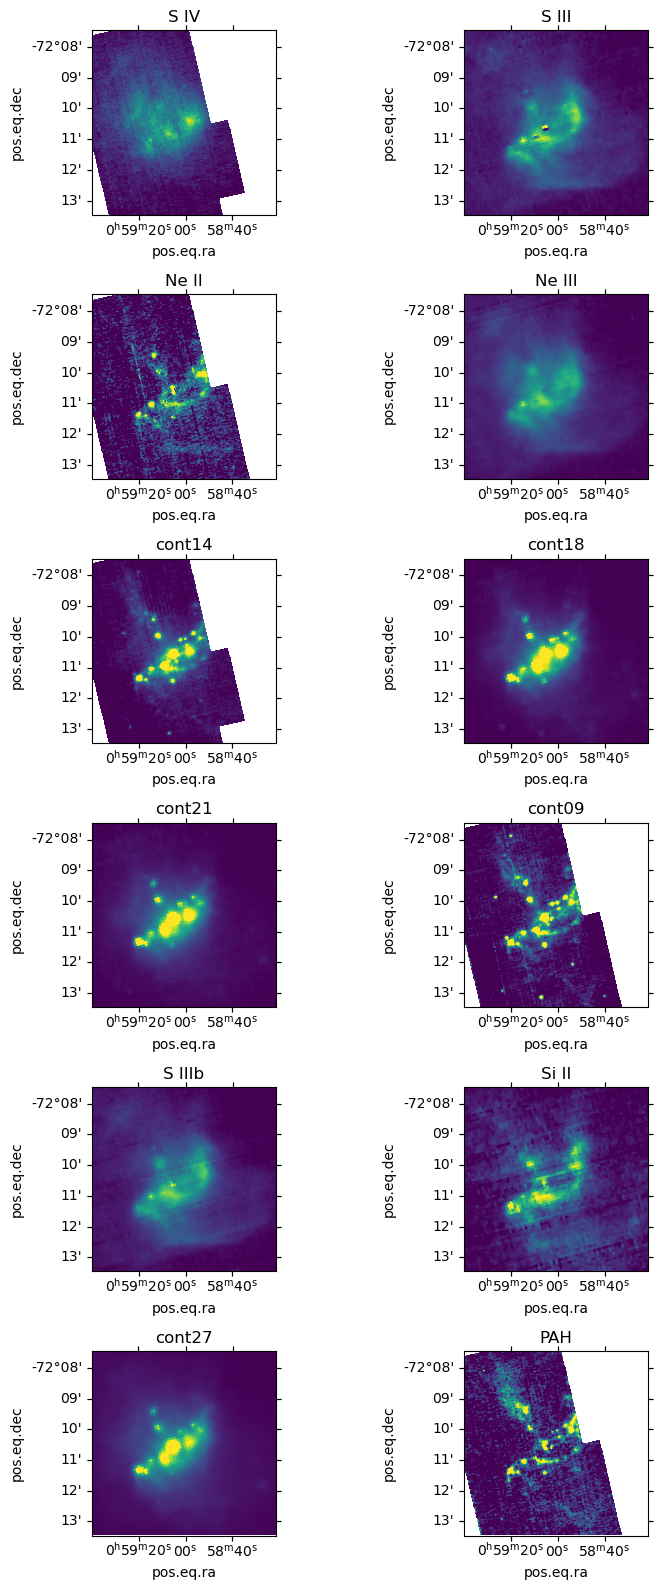

In [9]:
ncol = 2
fig, axes = plt.subplots(
    len(linedict) // 2,
    ncol,
    figsize=(8, 16),
    subplot_kw=dict(projection=w0),
)
bscale = {}
for ax, line in zip(axes.flat, linedict.keys()):
    mask = np.isfinite(maps[line])
    bscale[line] = 2 * np.percentile(maps[line][mask], 95)
    ax.imshow(maps[line], vmin=0, vmax=bscale[line])
    ax.set_title(line)
fig.tight_layout()

## Make ratios of the images

Define a `Ratio` class, which allows for the sum of one or more bands in both the numerator and denominator.  We only use this for [S III], which has two lines.

We use the same class for calculating equivalent widths as `LINE / CONTINUUM`. This requires "`EW`" to be in the `label` and an extra parameter `dwave` that is the sum of the widths of the continumm bands.

We calculate two different typical valuses for the ratio, the `median` (self-explanatory) and the `scale`, which is the ratio of the 95th centiles of the numerator and denominator. The `scale` turns out to be a better typical value.

In [10]:
@dataclass
class Ratio:
    label: str
    num: Union[str, list[str]]
    den: Union[str, list[str]]
    dwave: float = 1.0
    blur: float = 0.0

    def __post_init__(self):
        if isinstance(self.num, str):
            self.num = [self.num]
        if isinstance(self.den, str):
            self.den = [self.den]
        numerator = np.nansum(np.stack([maps[lab] for lab in self.num]), axis=0)
        denominator = np.nansum(np.stack([maps[lab] for lab in self.den]), axis=0)
        if self.blur > 0.0:
            kernel = Gaussian2DKernel(x_stddev=self.blur)
            numerator = convolve_fft(numerator, kernel, preserve_nan=True)
            denominator = convolve_fft(denominator, kernel, preserve_nan=True)
        self.ratio = np.where(
            (denominator > 0.0) & np.isfinite(denominator * numerator),
            numerator / denominator,
            np.nan
        )
        if "EW" in self.label:
            self.ratio *= self.dwave
        self.mask = np.isfinite(self.ratio)
        self.ratio[~self.mask] = np.nan
        self.scale = np.percentile(numerator[self.mask], 95) / np.percentile(
            denominator[self.mask], 95
        )
        self.median = np.nanmedian(self.ratio[self.mask])
        if "EW" in self.label:
            # The median is a better typical value for EWs
            self.scale = self.median

Take all the ratios that might occur to us.

In [11]:
ratios = [
    Ratio("s43", "S IV", ["S III", "S IIIb"]),
    Ratio("s33", "S III", "S IIIb"),
    Ratio("ne32", "Ne III", "Ne II"),
    Ratio("ne3s3", "Ne III", ["S III", "S IIIb"]),
    Ratio("color14-09", "cont14", "cont09"),
    Ratio("color21-18", "cont21", "cont18"),
    Ratio("color27-21", "cont27", "cont21"),
    Ratio("color27-14", "cont27", "cont14"),
    Ratio("EWs4", "S IV", ["cont09", "cont14"], dwave=2.5),
    Ratio("EWs3", "S III", "cont27", dwave=5.0),
    Ratio("EWs3b", "S IIIb", "cont27", dwave=5.0),
    Ratio("c14-s4", "cont14", "S IV"),
    Ratio("s4ne2", "S IV", "Ne II"),
    Ratio("c14-s3", "cont14", ["S III", "S IIIb"]),
    Ratio("si2-s3", "Si II", "S III"),
    Ratio("si2-ne2", "Si II", "Ne II"),
    Ratio("pah-ne2", "PAH", "Ne II"),
    Ratio("pah-c09", "PAH", "cont09"),
]

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,

### Plot the ratios

We use a logarithmic scale of two dex, centered on the `scale` value

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/37824920.py:11: RuntimeWarning: divide by zero encountered in log10  np.log10(rat.ratio),/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/37824920.py:11: RuntimeWarning: invalid value encountered in log10  np.log10(rat.ratio),

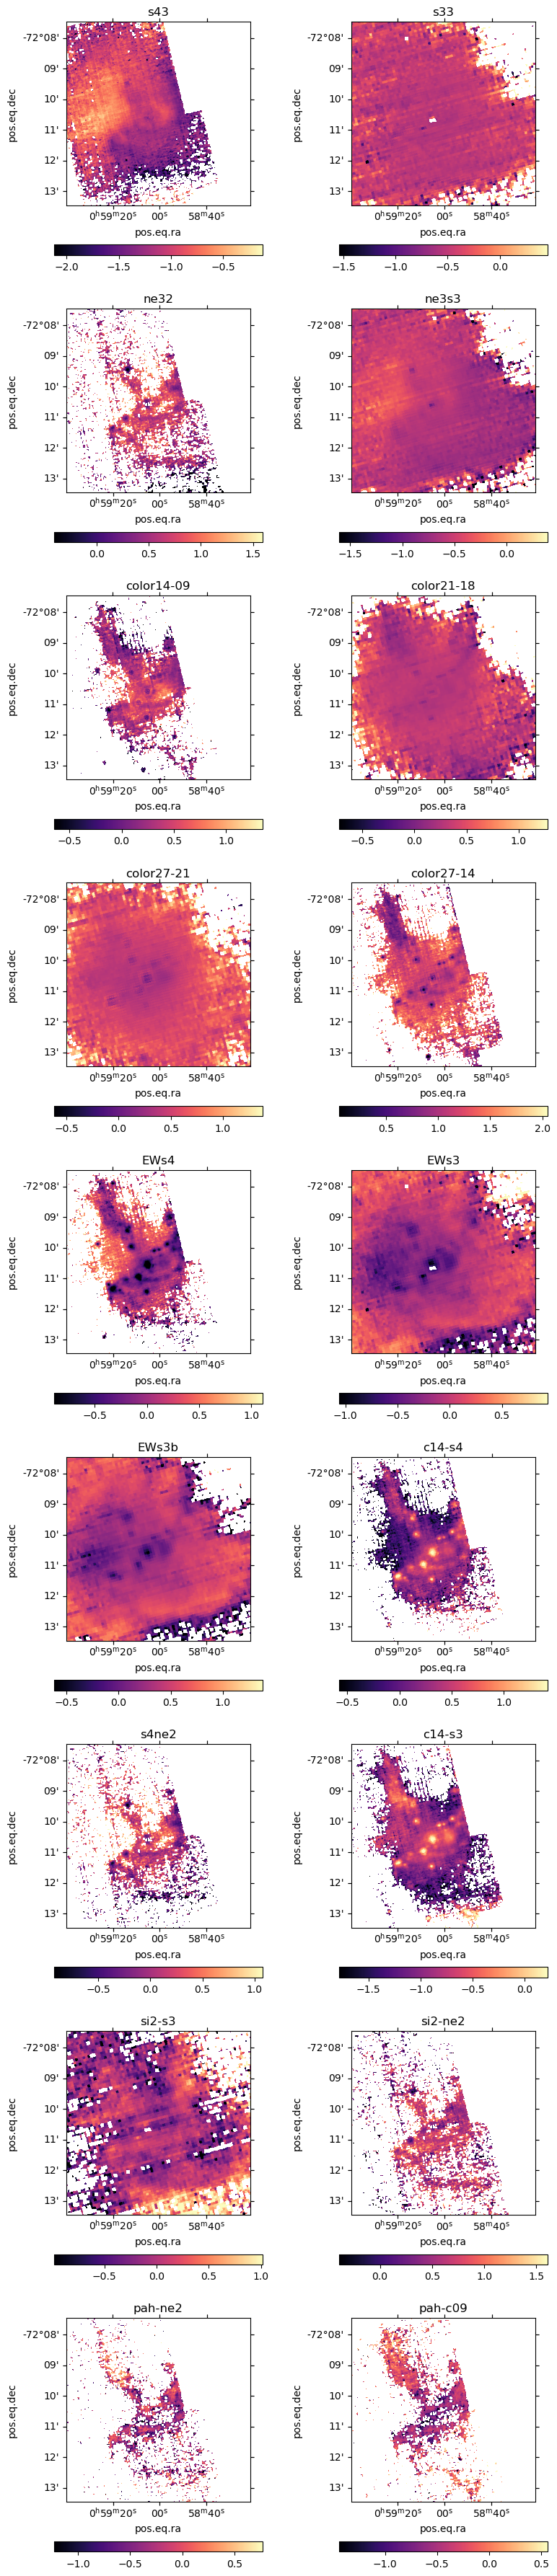

In [12]:
NCOL = 2
NROW = (len(ratios) + NCOL - 1) // NCOL
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(4 * NCOL, 4 * NROW),
    subplot_kw=dict(projection=w0),
)
for ax, rat in zip(axes.flat, ratios):
    im = ax.imshow(
        np.log10(rat.ratio),
        vmin=np.log10(rat.scale) - 1.0,
        vmax=np.log10(rat.scale) + 1.0,
        cmap="magma",
    )
    ax.set_title(rat.label)
    fig.colorbar(im, ax=ax, orientation="horizontal")
fig.tight_layout()

### Blurred versions of the ratios


In [13]:
bratios = [Ratio(r.label, r.num, r.den, r.dwave, blur=2.5) for r in ratios]

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/897185632.py:11: RuntimeWarning: divide by zero encountered in log10  np.log10(rat.ratio),/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/897185632.py:11: RuntimeWarning: invalid value encountered in log10  np.log10(rat.ratio),

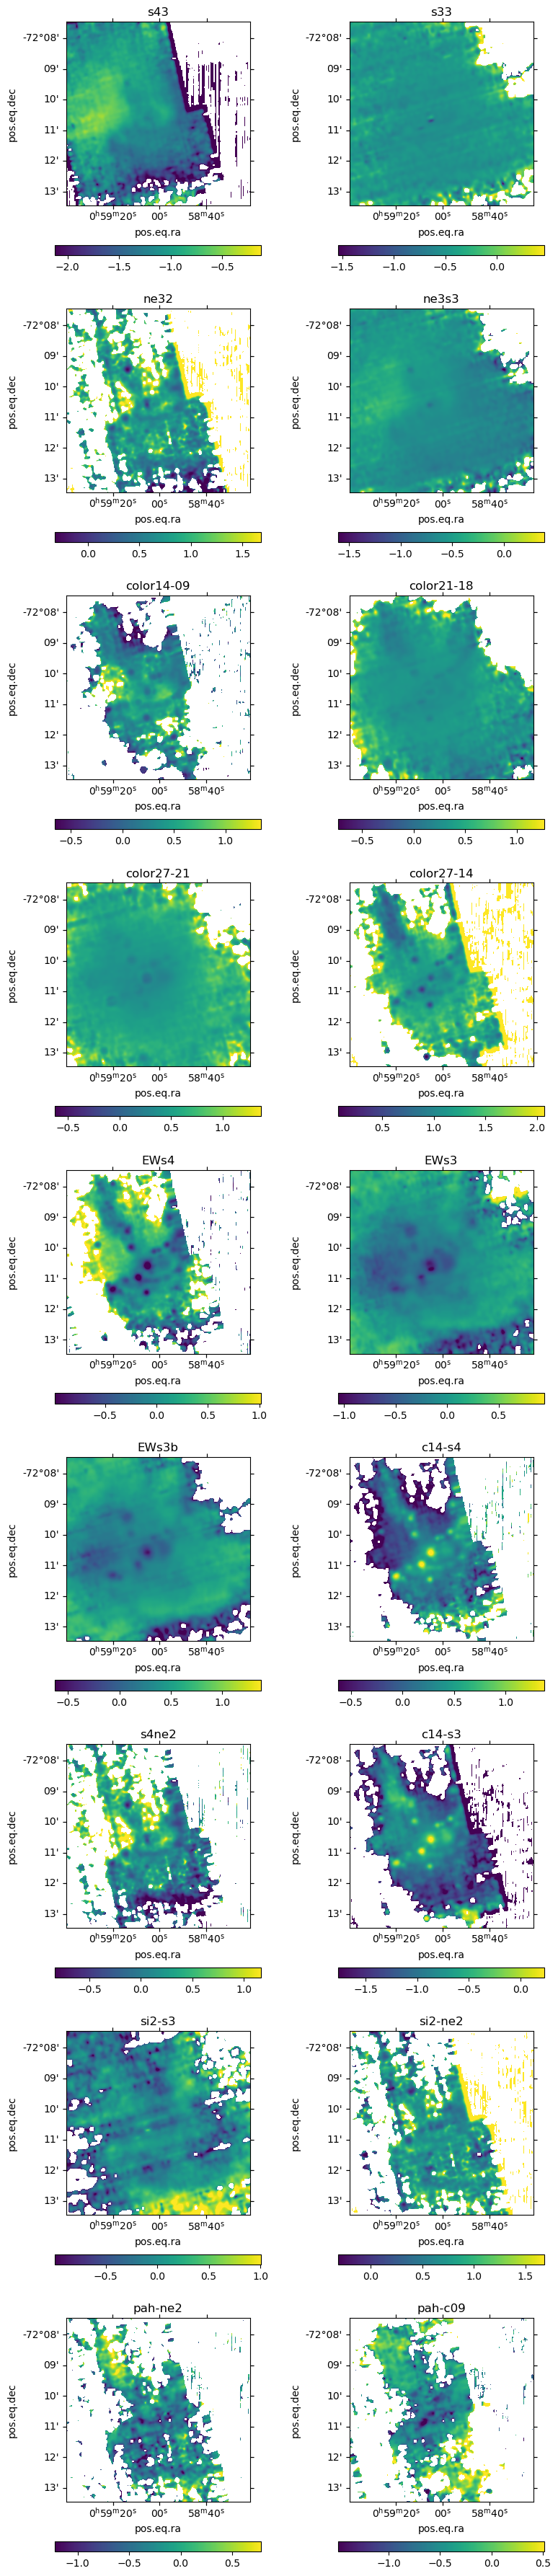

In [14]:
NCOL = 2
NROW = (len(bratios) + NCOL - 1) // NCOL
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(4 * NCOL, 4 * NROW),
    subplot_kw=dict(projection=w0),
)
for ax, rat in zip(axes.flat, bratios):
    im = ax.imshow(
        np.log10(rat.ratio),
        vmin=np.log10(rat.scale) - 1.0,
        vmax=np.log10(rat.scale) + 1.0,
        cmap="viridis",
    )
    ax.set_title(rat.label)
    fig.colorbar(im, ax=ax, orientation="horizontal")
fig.tight_layout()

## Color-color diagrams

### Define a function to make the color-color plots

Creates a 2d histogram from a pair of ratio images

In [15]:
def color_color_plot(rat1, rat2, weights, ax=None, nbins=100, wx=1.0, wy=1.0, aspect="equal"):
    mask = rat1.mask & rat2.mask & np.isfinite(weights) & (weights > 0.0)
    x = np.log10(rat1.ratio[mask])
    xmin = np.log10(rat1.scale) - wx
    xmax = np.log10(rat1.scale) + wx
    y = np.log10(rat2.ratio[mask])
    ymin = np.log10(rat2.scale) - wy
    ymax = np.log10(rat2.scale) + wy

    H, xedges, yedges = np.histogram2d(
        x,
        y,
        bins=nbins,
        range=[[xmin, xmax], [ymin, ymax]],
        density=True,
        weights=weights[mask],
    )
    if ax is None:
        ax = plt.gca()
    im = ax.imshow(
        H.T,
        extent=[xmin, xmax, ymin, ymax],
        origin="lower",
        aspect=aspect,
        cmap="inferno_r",
        interpolation="nearest",
    )
    ax.set(
        xlabel=f"log$_{{10}}$( {rat1.label} )",
        ylabel=f"log$_{{10}}$( {rat2.label} )",
    )
    return im

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])

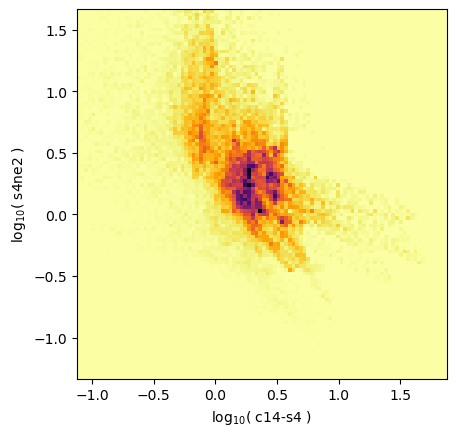

In [16]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("c14-s4", "cont14", "S IV", blur=2.5),
    Ratio("s4ne2", "S IV", "Ne II", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: divide by zero encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

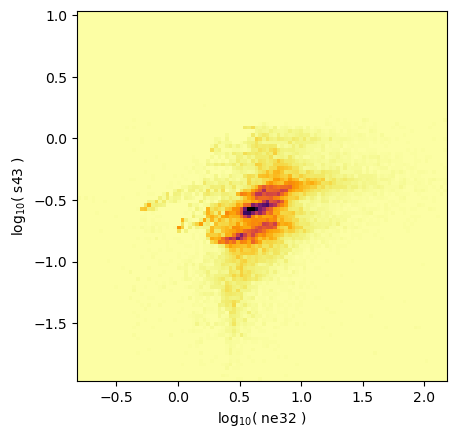

In [17]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne32", "Ne III", "Ne II", blur=2.5),
#    Ratio("s43", "S IV", ["S III", "S IIIb"], blur=2.5),
    Ratio("s43", "S IV", "S III", blur=2.5),
    maps["Ne II"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: divide by zero encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

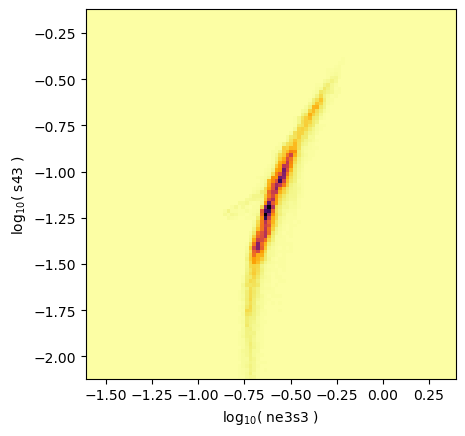

In [18]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3", "Ne III", ["S III", "S IIIb"], blur=2.5),
    Ratio("s43", "S IV", ["S III", "S IIIb"], blur=2.5),
    maps["S III"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

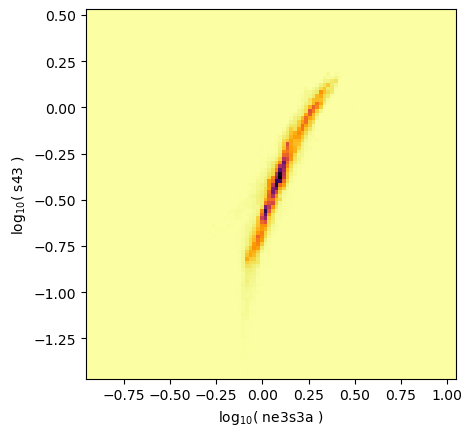

In [19]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3a", "Ne III", "S III", blur=2.5),
    Ratio("s43", "S IV", "S III", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

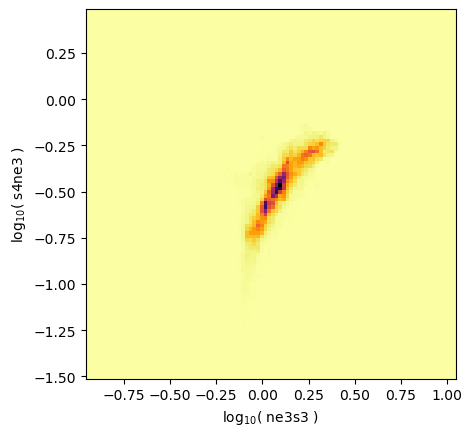

In [20]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3", "Ne III", "S III", blur=2.5),
    Ratio("s4ne3", "S IV", "Ne III", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

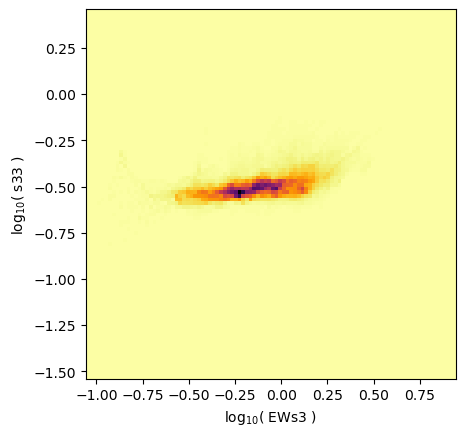

In [21]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("EWs3", "S III", "cont27", dwave=5.0, blur=2.5),
    Ratio("s33", "S III", "S IIIb", blur=2.5),
    maps["S III"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,

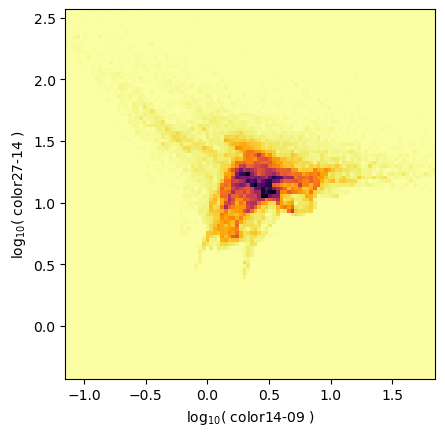

In [22]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
    Ratio("color27-14", "cont27", "cont14", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])

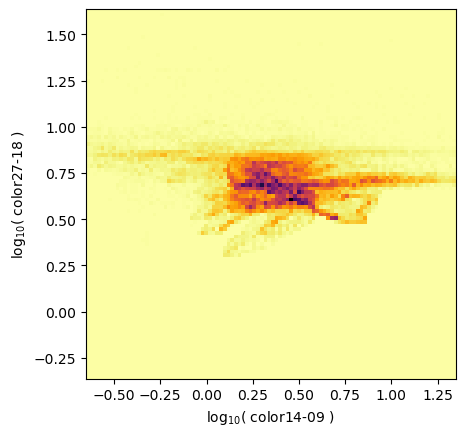

In [23]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
    Ratio("color27-18", "cont27", "cont18", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])

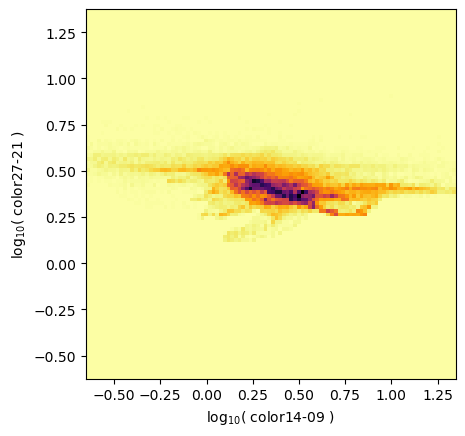

In [24]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
    Ratio("color27-21", "cont27", "cont21", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
#    wy=0.5,
#    aspect="auto",
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

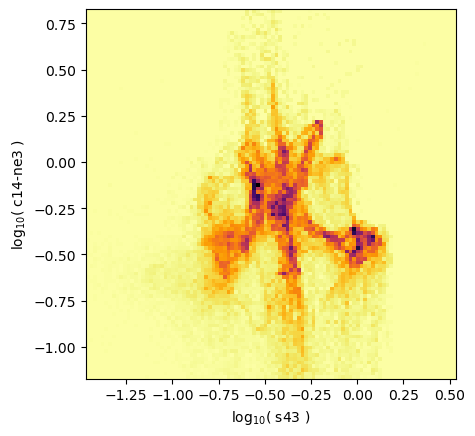

In [25]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("c14-ne3", "cont14", "Ne III", blur=2.5),
#   Ratio("c14-s4", "cont14", "S IV"),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

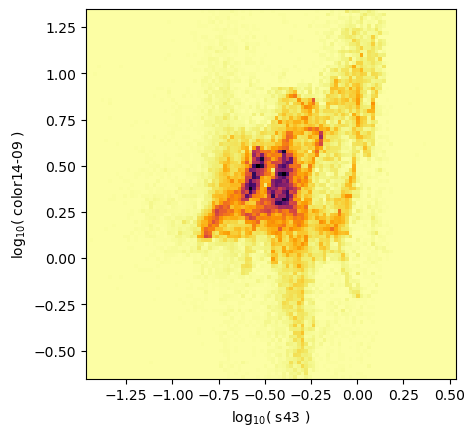

In [26]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
#    Ratio("color27-14", "cont27", "cont14"),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

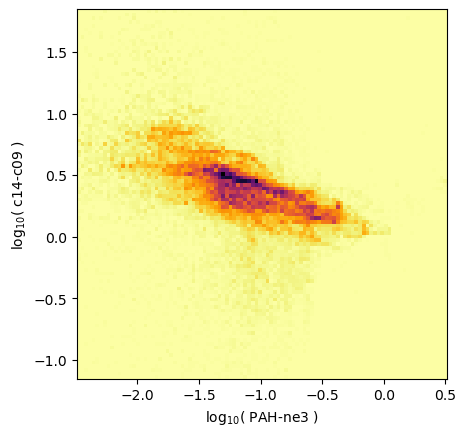

In [27]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("PAH-ne3", "PAH", "Ne III", blur=2.5),
    Ratio("c14-c09", "cont14", "cont09", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

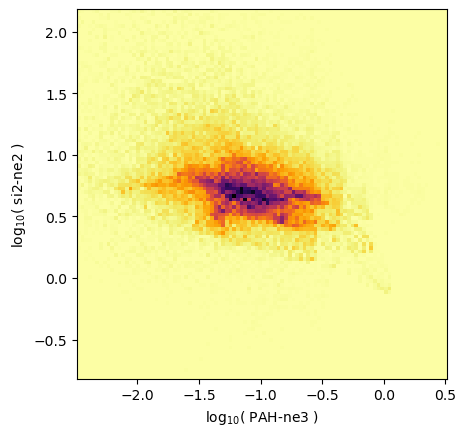

In [28]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("PAH-ne3", "PAH", "Ne III", blur=2.5),
    Ratio("si2-ne2", "Si II", "Ne II", blur=2.5),
    maps["S III"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

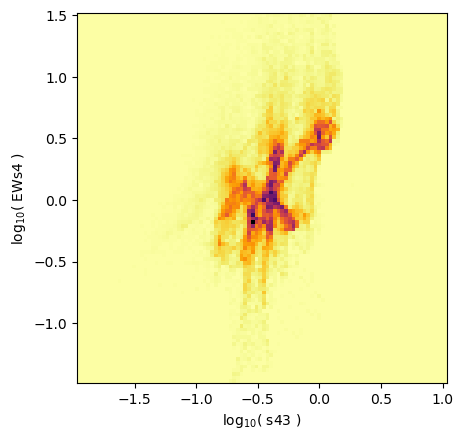

In [29]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("EWs4", "S IV", ["cont09", "cont14"], dwave=2.5, blur=2.5),
#    Ratio("EWs4", "S IV", ["cont14"], dwave=1.0),
    maps["S IV"],
#    maps["Ne III"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

### Use just the 18 micron S III line

This is to make for easier comparison with the Cloudy results. 

*Note that this section is a bit pointless now since I have gone back and redone many of the previous ratios with just the shorter line*



/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

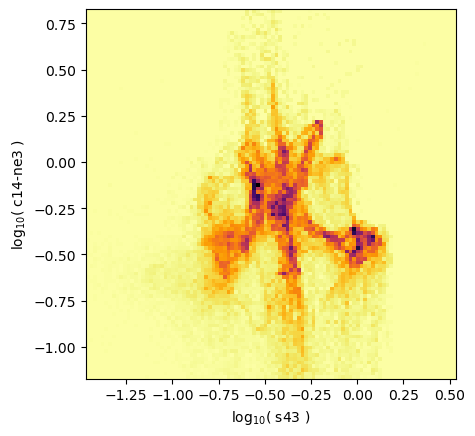

In [30]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("c14-ne3", "cont14", "Ne III", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

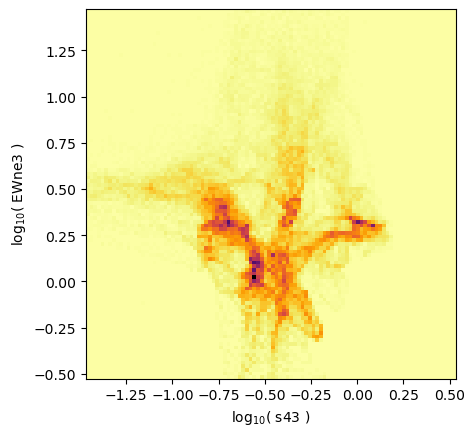

In [31]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("EWne3", "Ne III", ["cont14", "cont18"], dwave=3.0, blur=2.5),
    maps["Ne III"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])

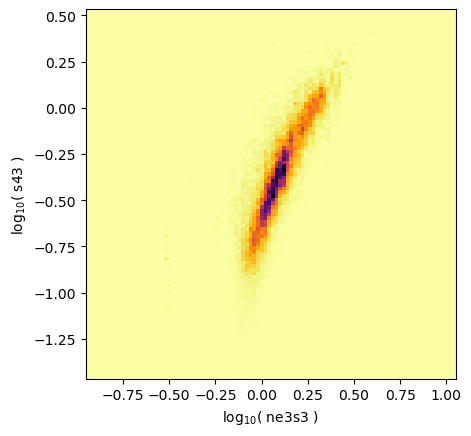

In [32]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3", "Ne III", "S III"),
    Ratio("s43", "S IV", "S III"),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])

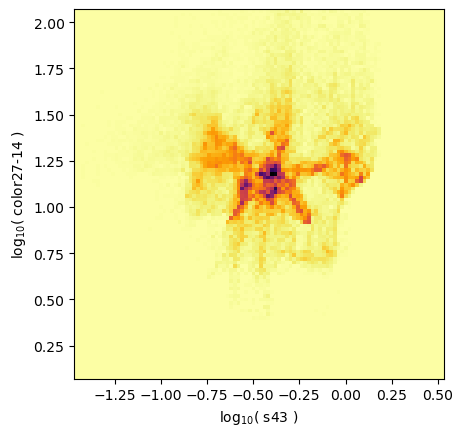

In [33]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
#    Ratio("color14-09", "cont14", "cont09"),
    Ratio("color27-14", "cont27", "cont14", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

So the above is a good diagnostic diagram for the bow shock. The bow shock region is `s43 > -0.3` and `color27-14 < 1.05`.

This distinguishes it from the SNR, which has redder continuum and higher s43. 

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

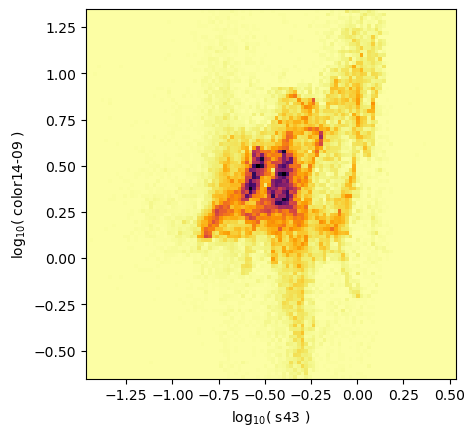

In [34]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
#    Ratio("color27-14", "cont27", "cont14"),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide  numerator / denominator,

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/1292939596.py:24: RuntimeWarning: divide by zero encountered in log10  np.log10(rat.ratio),/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/1292939596.py:24: RuntimeWarning: invalid value encountered in log10  np.log10(rat.ratio),/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/1292939596.py:30: RuntimeWarning: divide by zero encountered in log10  ax.contour(np.log10(rat.ratio), levels=leveldict[rat.label], colors="g", linestyles="solid")/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/1292939596.py:30: RuntimeWarning: invalid value encountered in log10  ax.contour(np.log10(rat.ratio), levels=leveldict[rat.label], colors="g", linestyles="solid")

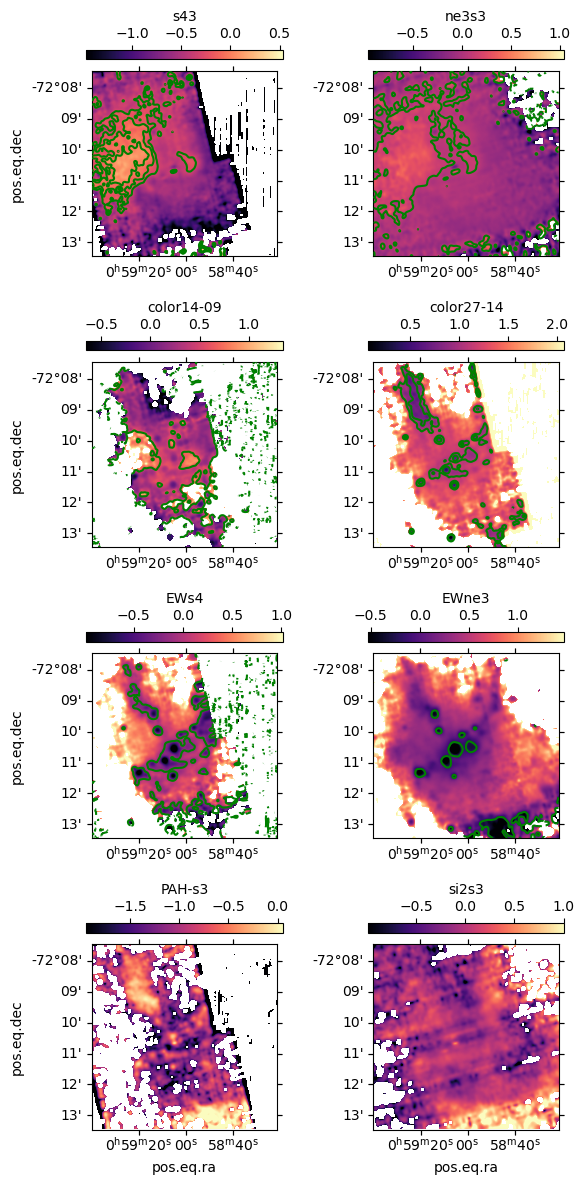

In [35]:
ratios = {
    "s43": Ratio("s43", "S IV", "S III", blur=2.5),
    "ne3s3": Ratio("ne3s3", "Ne III", "S III", blur=2.5),
    "color14-09": Ratio("color14-09", "cont14", "cont09", blur=2.5),
    "color27-14": Ratio("color27-14", "cont27", "cont14", blur=2.5),
    "EWs4": Ratio("EWs4", "S IV", ["cont09", "cont14"], dwave=2.5, blur=2.5),
    "EWne3": Ratio("EWne3", "Ne III", ["cont14", "cont18"], dwave=3.0, blur=2.5),
    "PAH-s3": Ratio("PAH-s3", "PAH", "S III", blur=2.5),
    "si2s3": Ratio("si2s3", "Si II", "S III", blur=2.5),
}
leveldict = {"s43": [-0.3, -0.15, 0.0], "ne3s3": [0.1], "color27-14": [0.8, 1.05], "color14-09": [0.6], "EWs4": [-0.15], "EWne3": [-0.2]}
NCOL = 2
NROW = (len(ratios) + NCOL - 1) // NCOL
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3 * NCOL, 3 * NROW),
    subplot_kw=dict(projection=w0),
    sharex=True,
    sharey=True,
)
for ax, rat in zip(axes.flat, ratios.values()):
    im = ax.imshow(
        np.log10(rat.ratio),
        vmin=np.log10(rat.scale) - 1.0,
        vmax=np.log10(rat.scale) + 1.0,
        cmap="magma",
    )
    if rat.label in leveldict:
        ax.contour(np.log10(rat.ratio), levels=leveldict[rat.label], colors="g", linestyles="solid")
    fig.colorbar(im, ax=ax, location="top", label=rat.label)
for ax in axes[:, 1:].flat:
    ax.coords[1].set_auto_axislabel(False)
for ax in axes[:-1, :].flat:
    ax.coords[0].set_auto_axislabel(False)
    
fig.tight_layout()

### Put all the best ratio-ratio plots together

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

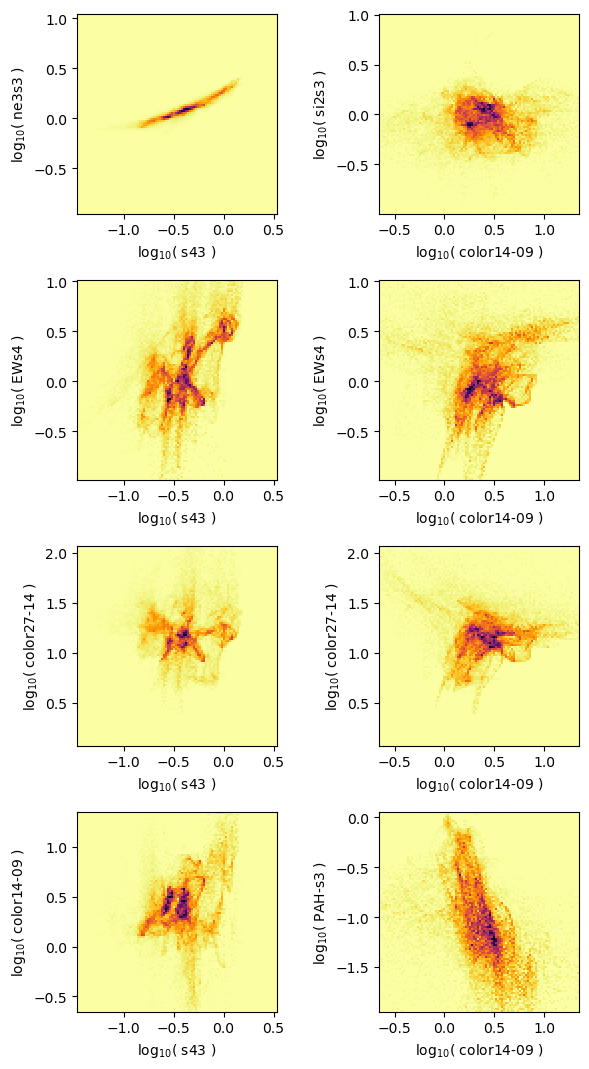

In [36]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
#    sharex="col",
#    sharey="row",
)
color_color_plot(ratios["s43"], ratios["ne3s3"], maps["S IV"], ax=axes[0, 0])
color_color_plot(ratios["s43"], ratios["EWs4"], maps["S IV"], ax=axes[1, 0])
color_color_plot(ratios["s43"], ratios["color27-14"], maps["S IV"], ax=axes[2, 0])
color_color_plot(ratios["s43"], ratios["color14-09"], maps["S IV"], ax=axes[3, 0])

color_color_plot(ratios["color14-09"], ratios["si2s3"], maps["S IV"], ax=axes[0, 1])
color_color_plot(ratios["color14-09"], ratios["EWs4"], maps["S IV"], ax=axes[1, 1])
color_color_plot(ratios["color14-09"], ratios["color27-14"], maps["S IV"], ax=axes[2, 1])
color_color_plot(ratios["color14-09"], ratios["PAH-s3"], maps["S IV"], ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [37]:
fig.savefig("midinfrared-ratio-ratio-plots.pdf", dpi=300, bbox_inches="tight")

### Try different types of weights

We could try having a weight that falls of with distance from the bowshock peak. Or from any other point for that matter. 

First get a coordinate grid for our images:

In [38]:
ny, nx = maps["S IV"].shape
xpix, ypix = np.meshgrid(np.arange(nx), np.arange(ny))
pixcoords = w0.pixel_to_world(xpix, ypix)
c0.to_pixel(w0)

(array(179.), array(179.))

So we can easily find the distance of each pixel from a particular point. For instance W3

In [39]:
pixcoords.separation(c0).arcsec

array([[253.14410057, 252.43798519, 251.7338616 , ..., 252.43798519,
        253.14410057, 253.85219111],
       [252.43798519, 251.72988912, 251.02377932, ..., 251.72988912,
        252.43798519, 253.14805085],
       [251.7338616 , 251.02377932, 250.31567766, ..., 251.02377932,
        251.7338616 , 252.44590779],
       ...,
       [252.43798519, 251.72988912, 251.02377932, ..., 251.72988912,
        252.43798519, 253.14805085],
       [253.14410057, 252.43798519, 251.7338616 , ..., 252.43798519,
        253.14410057, 253.85219111],
       [253.85219111, 253.14805085, 252.44590779, ..., 253.14805085,
        253.85219111, 254.55831199]])

Now make a function to make a weight array that falls off with distance from a point. Would be easier to do it in pixel space, so we won't actually be using separation. We need to make sure that the WCS object knows about the image shape via the `.array_shape` attribute, which is optional.

In [40]:
from astropy.modeling.models import Gaussian2D, Sersic2D

def get_spatial_weight_array(center: SkyCoord, width: float, wcs: WCS, axis_ratio=1.0, theta=0.0):
    """
    Create image of elliptical gaussian profile, defined by parameters:
    
        center is celestial coordinate of peak position
        wcs defines pixel-to-celestial mapping
        width is major axis in pixels (x axis before rotation)
        axis_ratio < 1 for narrower in y (before rotation)
        theta is rotation of major axis counterclockwise from x axis (in degrees)

    Returns 2D image data array
    """
    assert wcs.array_shape is not None and len(wcs.array_shape) >= 2
    # Get pixel coordinates of image
    xpix, ypix = np.meshgrid(np.arange(wcs.array_shape[1]), np.arange(wcs.array_shape[0]))
    #  Pixel coordinates of peak
    xc, yc = center.to_pixel(wcs)
    
    model = Gaussian2D(
        amplitude=1.0, 
        x_mean=xc, 
        y_mean=yc, 
        x_stddev=width, 
        y_stddev=axis_ratio * width, 
        theta=np.deg2rad(theta),
    )
    return model(xpix, ypix)


#### Select bow shock only

Test it out by moving 10 arcsec to West of star to get approximate center of bow shock

In [41]:
cbow = c0.spherical_offsets_by(-10 * u.arcsec, 0.0 * u.arcsec)
cbow

<SkyCoord (ICRS): (ra, dec) in deg
    (14.74408908, -72.17449196)>

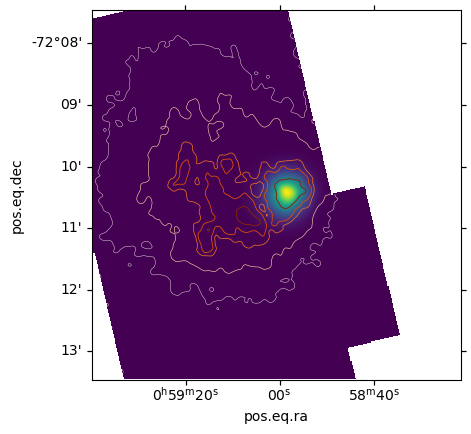

In [42]:
weights_bow = get_spatial_weight_array(cbow, 15, w0)
map_bow = convolve_fft(maps["S IV"], Gaussian2DKernel(x_stddev=2.5), preserve_nan=True)

fig, ax = plt.subplots(subplot_kw=dict(projection=w0))
ax.imshow(weights_bow * map_bow)

levels = np.nanpercentile(map_bow, [50, 75, 90, 95, 99])
linewidths = 0.3 * np.sqrt(1 + np.arange(len(levels)))
ax.contour(map_bow, levels=levels, cmap="Oranges", linewidths=linewidths)


/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])

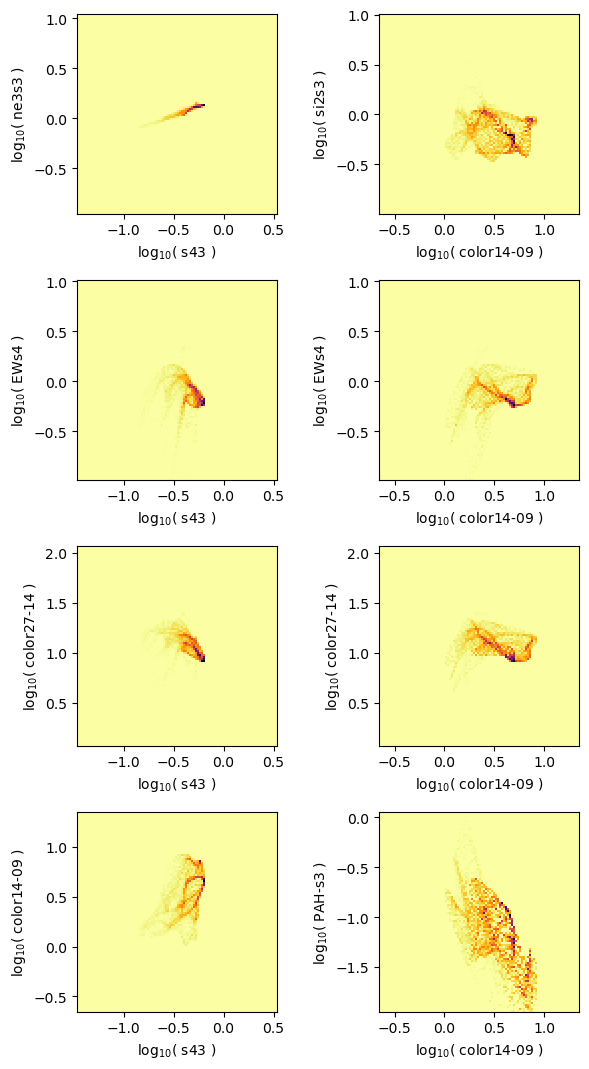

In [43]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
)
weights = weights_bow * map_bow

color_color_plot(ratios["s43"], ratios["ne3s3"], weights, ax=axes[0, 0])
color_color_plot(ratios["s43"], ratios["EWs4"], weights, ax=axes[1, 0])
color_color_plot(ratios["s43"], ratios["color27-14"], weights, ax=axes[2, 0])
color_color_plot(ratios["s43"], ratios["color14-09"], weights, ax=axes[3, 0])

color_color_plot(ratios["color14-09"], ratios["si2s3"], weights, ax=axes[0, 1])
color_color_plot(ratios["color14-09"], ratios["EWs4"], weights, ax=axes[1, 1])
color_color_plot(ratios["color14-09"], ratios["color27-14"], weights, ax=axes[2, 1])
color_color_plot(ratios["color14-09"], ratios["PAH-s3"], weights, ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [44]:
fig.savefig("midinfrared-ratio-ratio-plots-bow.pdf", dpi=300, bbox_inches="tight")

#### Select SNR only 

Get position of SNR

In [45]:
csnr = SkyCoord.from_name("SNR B0057-72.2")

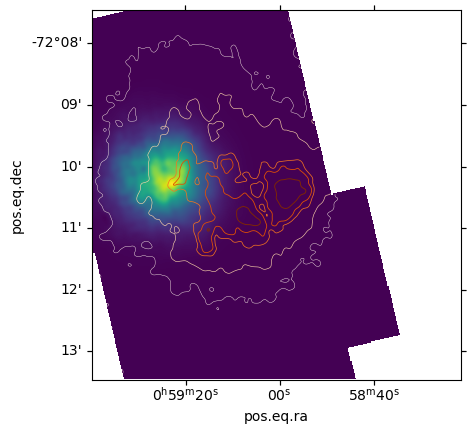

In [46]:
weights_snr = get_spatial_weight_array(csnr, 30, w0)
map_snr = convolve_fft(maps["S IV"], Gaussian2DKernel(x_stddev=2.5), preserve_nan=True)

fig, ax = plt.subplots(subplot_kw=dict(projection=w0))
ax.imshow(weights_snr * map_snr) 

levels = np.nanpercentile(map_snr, [50, 75, 90, 95, 99])
linewidths = 0.3 * np.sqrt(1 + np.arange(len(levels)))
ax.contour(map_snr, levels=levels, cmap="Oranges", linewidths=linewidths)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])

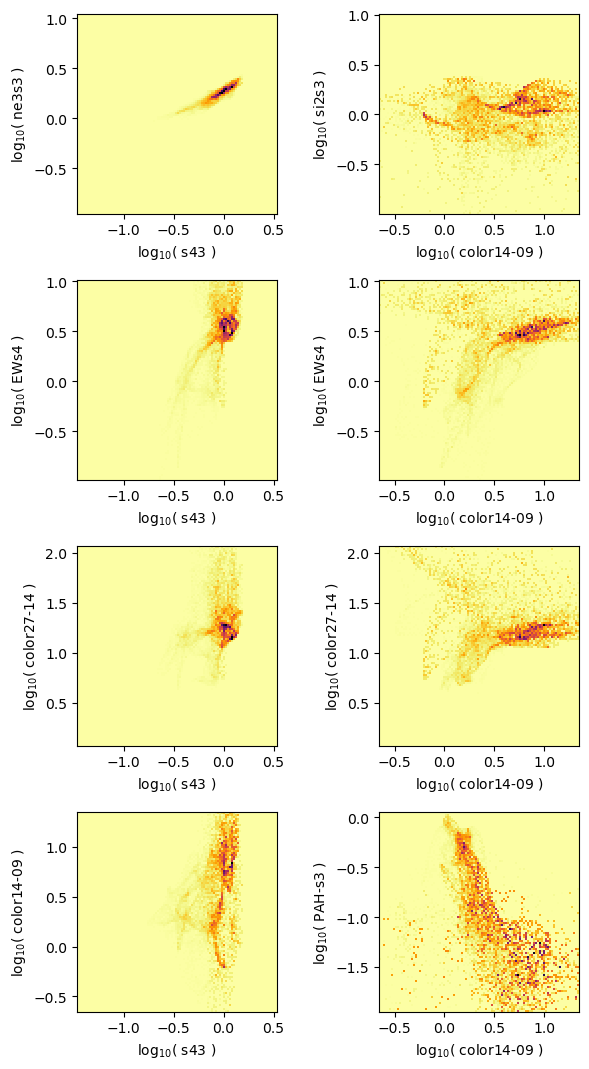

In [47]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
)
weights = weights_snr * map_snr

color_color_plot(ratios["s43"], ratios["ne3s3"], weights, ax=axes[0, 0])
color_color_plot(ratios["s43"], ratios["EWs4"], weights, ax=axes[1, 0])
color_color_plot(ratios["s43"], ratios["color27-14"], weights, ax=axes[2, 0])
color_color_plot(ratios["s43"], ratios["color14-09"], weights, ax=axes[3, 0])

color_color_plot(ratios["color14-09"], ratios["si2s3"], weights, ax=axes[0, 1])
color_color_plot(ratios["color14-09"], ratios["EWs4"], weights, ax=axes[1, 1])
color_color_plot(ratios["color14-09"], ratios["color27-14"], weights, ax=axes[2, 1])
color_color_plot(ratios["color14-09"], ratios["PAH-s3"], weights, ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [48]:
fig.savefig("midinfrared-ratio-ratio-plots-snr.pdf", dpi=300, bbox_inches="tight")

#### Select MYSO only 

Get position of massive YSO C

In [49]:
cyso = SkyCoord.from_name("Cl* NGC 346 SSN 152")

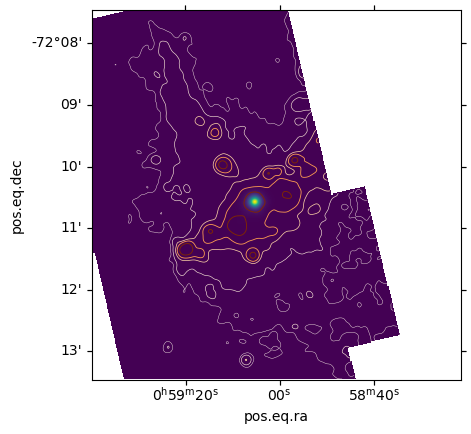

In [50]:
weights_yso = get_spatial_weight_array(cyso, 8, w0)
map_yso = convolve_fft(maps["cont14"], Gaussian2DKernel(x_stddev=2.5), preserve_nan=True)

fig, ax = plt.subplots(subplot_kw=dict(projection=w0))
ax.imshow(weights_yso * map_yso)

levels = np.nanpercentile(map_yso, [50, 75, 90, 95, 99])
linewidths = 0.3 * np.sqrt(1 + np.arange(len(levels)))
ax.contour(map_yso, levels=levels, cmap="Oranges", linewidths=linewidths)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

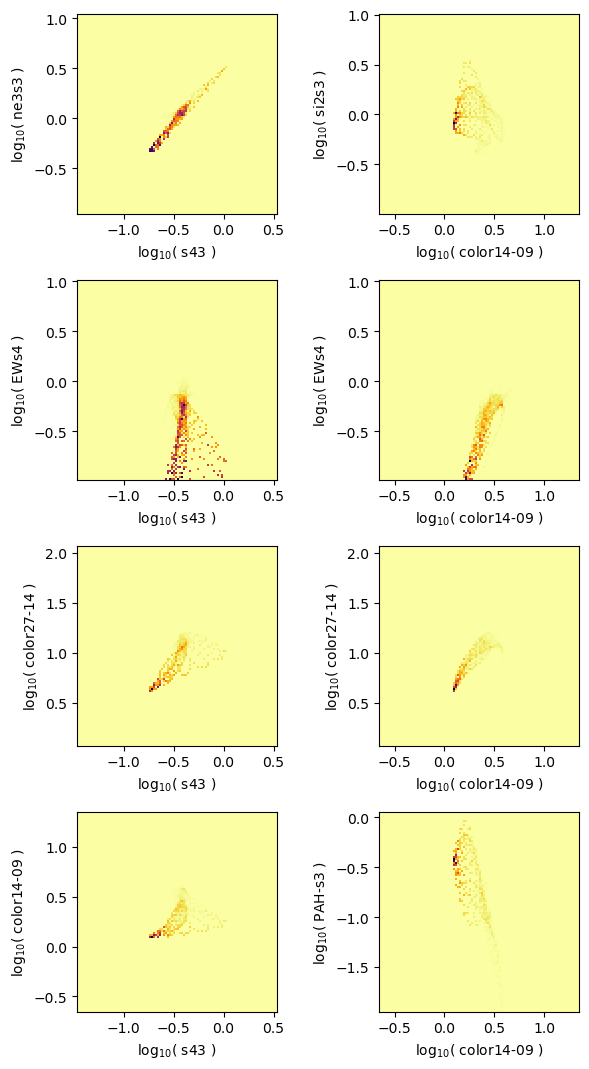

In [51]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
)
weights = weights_yso * map_yso

color_color_plot(ratios["s43"], ratios["ne3s3"], weights, ax=axes[0, 0])
color_color_plot(ratios["s43"], ratios["EWs4"], weights, ax=axes[1, 0])
color_color_plot(ratios["s43"], ratios["color27-14"], weights, ax=axes[2, 0])
color_color_plot(ratios["s43"], ratios["color14-09"], weights, ax=axes[3, 0])

color_color_plot(ratios["color14-09"], ratios["si2s3"], weights, ax=axes[0, 1])
color_color_plot(ratios["color14-09"], ratios["EWs4"], weights, ax=axes[1, 1])
color_color_plot(ratios["color14-09"], ratios["color27-14"], weights, ax=axes[2, 1])
color_color_plot(ratios["color14-09"], ratios["PAH-s3"], weights, ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [52]:
fig.savefig("midinfrared-ratio-ratio-plots-yso-c.pdf", dpi=300, bbox_inches="tight")

#### Select plume only

The plume is the ridge that goes of to the NNE, perpendicular to the main filaments. 

We can define its central point it by one of the sub-clusters `[SGK2009] B` from Schmeja et a 2009ApJ...694..367S 


In [53]:
cplume = SkyCoord.from_name("[SGK2009] B")

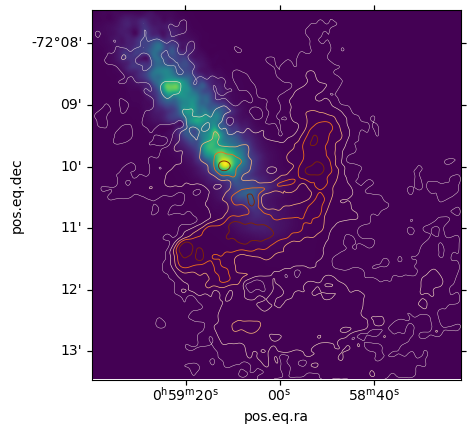

In [54]:
weights_plume = get_spatial_weight_array(cplume, 60, w0, axis_ratio=0.3, theta=125)
weights_plume *= (1 - weights_snr)
map_plume = convolve_fft(maps["Si II"], Gaussian2DKernel(x_stddev=2.5), preserve_nan=True)

fig, ax = plt.subplots(subplot_kw=dict(projection=w0))
ax.imshow(weights_plume * map_plume)

levels = np.nanpercentile(map_plume, [50, 75, 90, 95, 99])
linewidths = 0.3 * np.sqrt(1 + np.arange(len(levels)))
ax.contour(map_plume, levels=levels, cmap="Oranges", linewidths=linewidths)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: divide by zero encountered in log10  y = np.log10(rat2.ratio[mask])

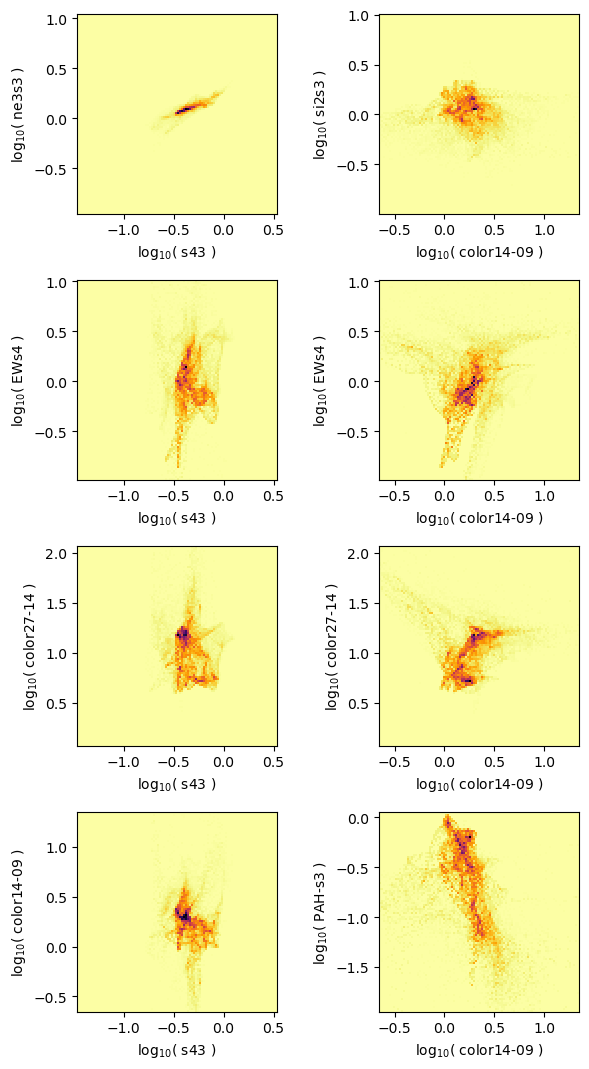

In [55]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
)
weights = weights_plume * map_plume

color_color_plot(ratios["s43"], ratios["ne3s3"], weights, ax=axes[0, 0])
color_color_plot(ratios["s43"], ratios["EWs4"], weights, ax=axes[1, 0])
color_color_plot(ratios["s43"], ratios["color27-14"], weights, ax=axes[2, 0])
color_color_plot(ratios["s43"], ratios["color14-09"], weights, ax=axes[3, 0])

color_color_plot(ratios["color14-09"], ratios["si2s3"], weights, ax=axes[0, 1])
color_color_plot(ratios["color14-09"], ratios["EWs4"], weights, ax=axes[1, 1])
color_color_plot(ratios["color14-09"], ratios["color27-14"], weights, ax=axes[2, 1])
color_color_plot(ratios["color14-09"], ratios["PAH-s3"], weights, ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [56]:
fig.savefig("midinfrared-ratio-ratio-plots-plume.pdf", dpi=300, bbox_inches="tight")

It is interesting that this has some overlap with the bow shock on the s43-EWs4 diagram, which I did not expect. On the other hand, there is a clear separation on the pure continuum color-color diagram: 14/09 vs 27/14

#### Select filaments only

Here it is a bit trickier to define their position. I will try and pick out 3 filaments

In [57]:
cfil01 = SkyCoord.from_name("[SSN2007] Sc 1")
cfil02 = SkyCoord.from_name("[SSN2007] Sc 2")
cfil03 = SkyCoord.from_name("[SSN2007] Sc 7")

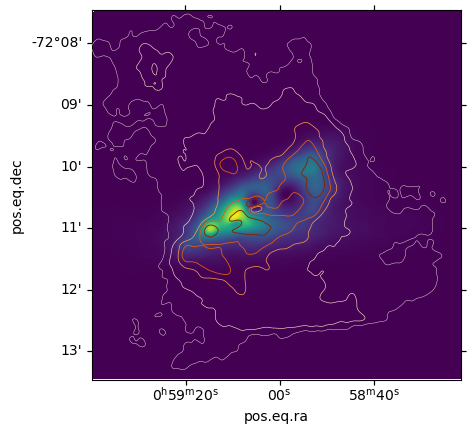

In [58]:
weights_fil = 2 * get_spatial_weight_array(cfil01, 60, w0, axis_ratio=0.2, theta=30)
weights_fil += get_spatial_weight_array(cfil02, 60, w0, axis_ratio=0.2, theta=15)
weights_fil += get_spatial_weight_array(cfil03, 90, w0, axis_ratio=0.2, theta=0)
# remove the YSO and bow
weights_fil *= (1 - weights_yso)
weights_fil *= (1 - weights_bow)
weights_fil *= (1 - weights_snr)
weights_fil /= np.max(weights_fil)

map_fil = convolve_fft(maps["S III"], Gaussian2DKernel(x_stddev=2.5), preserve_nan=True)

fig, ax = plt.subplots(subplot_kw=dict(projection=w0))
ax.imshow(weights_fil * map_fil)

levels = np.nanpercentile(map_fil, [50, 75, 90, 95, 99])
linewidths = 0.3 * np.sqrt(1 + np.arange(len(levels)))
ax.contour(map_fil, levels=levels, cmap="Oranges", linewidths=linewidths)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: divide by zero encountered in log10  y = np.log10(rat2.ratio[mask])

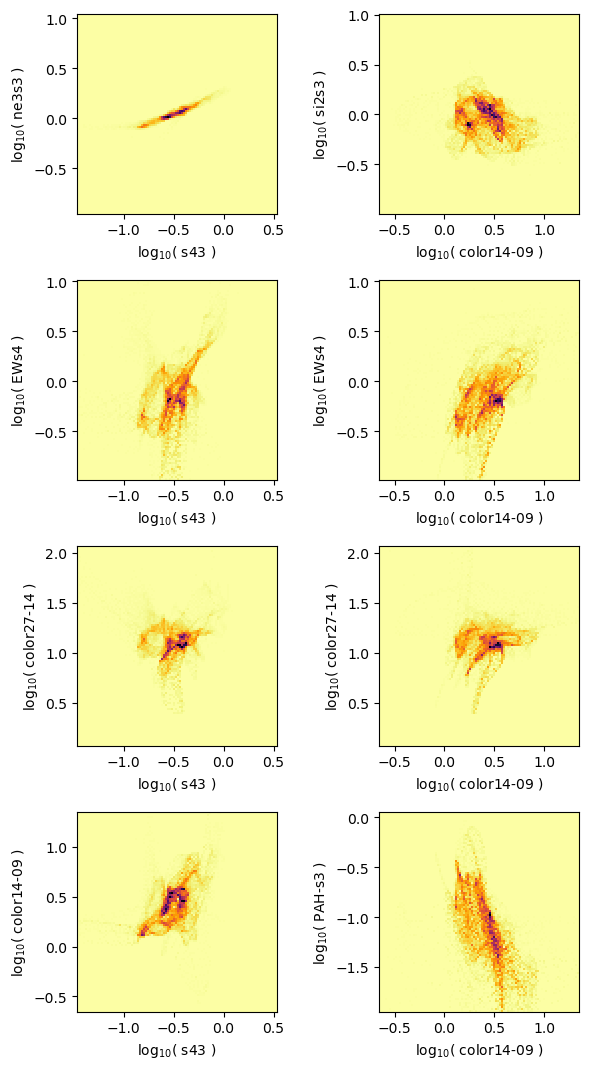

In [59]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
)
weights = weights_fil * map_fil

color_color_plot(ratios["s43"], ratios["ne3s3"], weights, ax=axes[0, 0])
color_color_plot(ratios["s43"], ratios["EWs4"], weights, ax=axes[1, 0])
color_color_plot(ratios["s43"], ratios["color27-14"], weights, ax=axes[2, 0])
color_color_plot(ratios["s43"], ratios["color14-09"], weights, ax=axes[3, 0])

color_color_plot(ratios["color14-09"], ratios["si2s3"], weights, ax=axes[0, 1])
color_color_plot(ratios["color14-09"], ratios["EWs4"], weights, ax=axes[1, 1])
color_color_plot(ratios["color14-09"], ratios["color27-14"], weights, ax=axes[2, 1])
color_color_plot(ratios["color14-09"], ratios["PAH-s3"], weights, ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [60]:
fig.savefig("midinfrared-ratio-ratio-plots-fil.pdf", dpi=300, bbox_inches="tight")

#### Select SE filament only

There is another filament in the SE that seems different

In [61]:
cse = SkyCoord.from_name("[SSN2007] Sc 12")

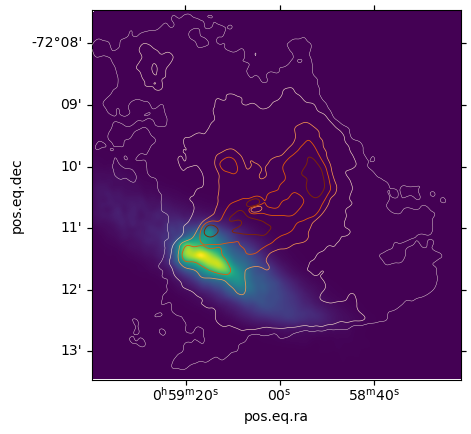

In [62]:
weights_se = get_spatial_weight_array(cse, 90, w0, axis_ratio=0.2, theta=-30)

# remove other nearby regions
weights_fil *= (1 - weights_fil)
weights_fil *= (1 - weights_snr)

map_se = convolve_fft(maps["S III"], Gaussian2DKernel(x_stddev=2.5), preserve_nan=True)

fig, ax = plt.subplots(subplot_kw=dict(projection=w0))
ax.imshow(weights_se * map_se)

levels = np.nanpercentile(map_se, [50, 75, 90, 95, 99])
linewidths = 0.3 * np.sqrt(1 + np.arange(len(levels)))
ax.contour(map_se, levels=levels, cmap="Oranges", linewidths=linewidths)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: divide by zero encountered in log10  y = np.log10(rat2.ratio[mask])

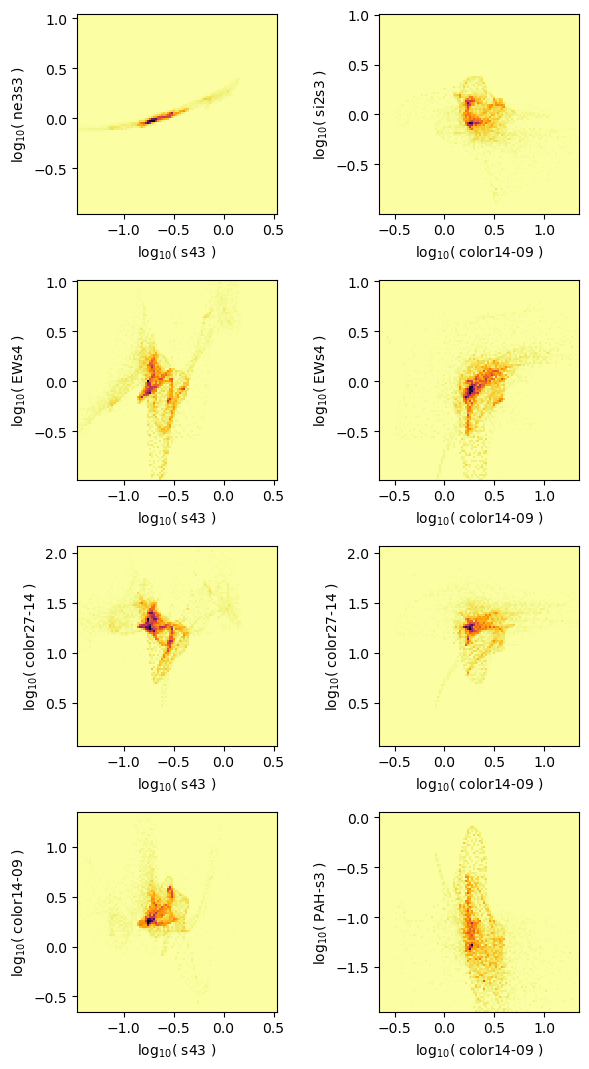

In [63]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
)
weights = weights_se * map_se

color_color_plot(ratios["s43"], ratios["ne3s3"], weights, ax=axes[0, 0])
color_color_plot(ratios["s43"], ratios["EWs4"], weights, ax=axes[1, 0])
color_color_plot(ratios["s43"], ratios["color27-14"], weights, ax=axes[2, 0])
color_color_plot(ratios["s43"], ratios["color14-09"], weights, ax=axes[3, 0])

color_color_plot(ratios["color14-09"], ratios["si2s3"], weights, ax=axes[0, 1])
color_color_plot(ratios["color14-09"], ratios["EWs4"], weights, ax=axes[1, 1])
color_color_plot(ratios["color14-09"], ratios["color27-14"], weights, ax=axes[2, 1])
color_color_plot(ratios["color14-09"], ratios["PAH-s3"], weights, ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [64]:
fig.savefig("midinfrared-ratio-ratio-plots-se.pdf", dpi=300, bbox_inches="tight")

#### Select outer swoop only
We can use a YSO that is seen in the center of this feature: `[SBW2007b] 73`


In [65]:
cswoop = SkyCoord.from_name("[SBW2007b] 73")

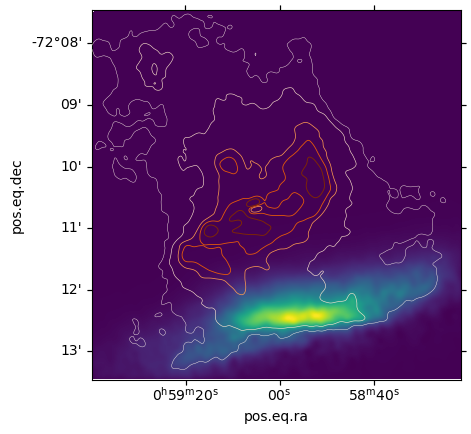

In [66]:
weights_swoop = get_spatial_weight_array(cswoop, 120, w0, axis_ratio=0.2, theta=15)
map_swoop = convolve_fft(maps["S III"], Gaussian2DKernel(x_stddev=2.5), preserve_nan=True)
fig, ax = plt.subplots(subplot_kw=dict(projection=w0))
ax.imshow(map_swoop * weights_swoop)

levels = np.nanpercentile(map_swoop, [50, 75, 90, 95, 99])
linewidths = 0.3 * np.sqrt(1 + np.arange(len(levels)))
ax.contour(map_swoop, levels=levels, cmap="Oranges", linewidths=linewidths)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: divide by zero encountered in log10  y = np.log10(rat2.ratio[mask])

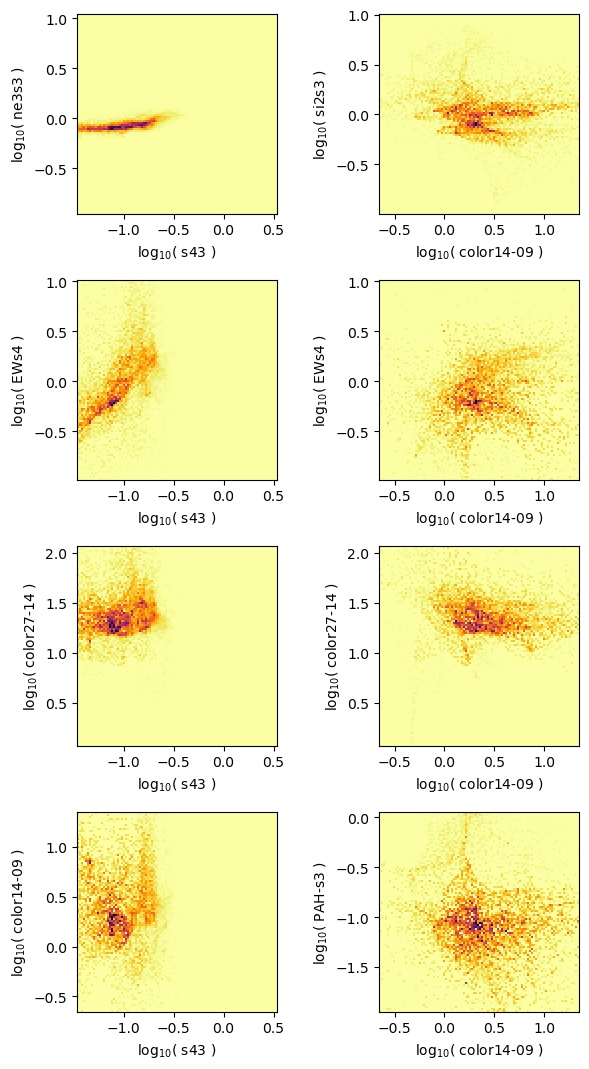

In [67]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
)
weights = weights_swoop * map_swoop

color_color_plot(ratios["s43"], ratios["ne3s3"], weights, ax=axes[0, 0])
color_color_plot(ratios["s43"], ratios["EWs4"], weights, ax=axes[1, 0])
color_color_plot(ratios["s43"], ratios["color27-14"], weights, ax=axes[2, 0])
color_color_plot(ratios["s43"], ratios["color14-09"], weights, ax=axes[3, 0])

color_color_plot(ratios["color14-09"], ratios["si2s3"], weights, ax=axes[0, 1])
color_color_plot(ratios["color14-09"], ratios["EWs4"], weights, ax=axes[1, 1])
color_color_plot(ratios["color14-09"], ratios["color27-14"], weights, ax=axes[2, 1])
color_color_plot(ratios["color14-09"], ratios["PAH-s3"], weights, ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [68]:
fig.savefig("midinfrared-ratio-ratio-plots-swoop.pdf", dpi=300, bbox_inches="tight")

#### Now look at what is left over


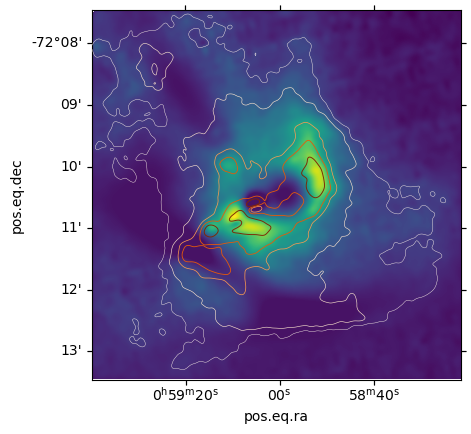

In [69]:

weights_all = (
    weights_bow + weights_snr + weights_yso + weights_plume 
    + weights_fil + weights_se + weights_swoop
)
weights_rest = np.maximum(1 - weights_all, 0.0)
# eliminate the inner part
#weights_rest *= (1 - get_spatial_weight_array(cyso, 180, w0))

map_rest = convolve_fft(maps["S III"], Gaussian2DKernel(x_stddev=2.5), preserve_nan=True)

fig, ax = plt.subplots(subplot_kw=dict(projection=w0))
ax.imshow(weights_rest * map_rest)
#ax.imshow(weights_rest)

levels = np.nanpercentile(map_rest, [50, 75, 90, 95, 99])
linewidths = 0.3 * np.sqrt(1 + np.arange(len(levels)))
ax.contour(map_rest, levels=levels, cmap="Oranges", linewidths=linewidths)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:3: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3913736200.py:6: RuntimeWarning: divide by zero encountered in log10  y = np.log10(rat2.ratio[mask])

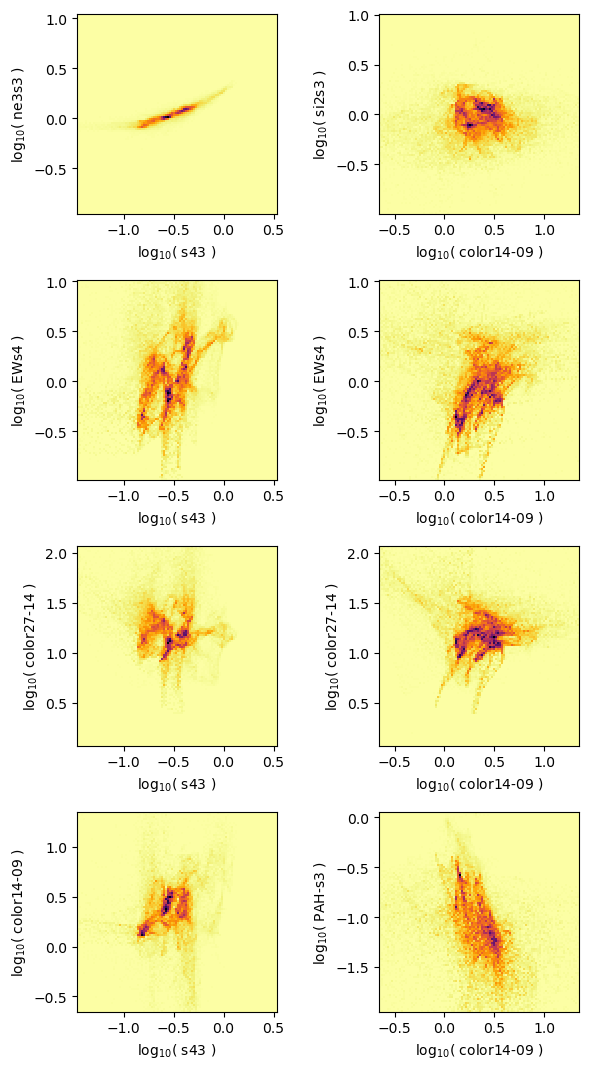

In [70]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
)
weights = weights_rest * map_rest

color_color_plot(ratios["s43"], ratios["ne3s3"], weights, ax=axes[0, 0])
color_color_plot(ratios["s43"], ratios["EWs4"], weights, ax=axes[1, 0])
color_color_plot(ratios["s43"], ratios["color27-14"], weights, ax=axes[2, 0])
color_color_plot(ratios["s43"], ratios["color14-09"], weights, ax=axes[3, 0])

color_color_plot(ratios["color14-09"], ratios["si2s3"], weights, ax=axes[0, 1])
color_color_plot(ratios["color14-09"], ratios["EWs4"], weights, ax=axes[1, 1])
color_color_plot(ratios["color14-09"], ratios["color27-14"], weights, ax=axes[2, 1])
color_color_plot(ratios["color14-09"], ratios["PAH-s3"], weights, ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [71]:
fig.savefig("midinfrared-ratio-ratio-plots-rest.pdf", dpi=300, bbox_inches="tight")

### Now try and combine all of these with different colors

I can try something similar to what I did with the spatial zones in the Mabel paper. Except that maybe add an alpha channel too. 

In [72]:
colordb = {
    "black": (0, 0, 0),
    "blue": (250, 90, 30),
    "purple": (290, 70, 40),
    "magenta": (352, 80, 50),
    "red": (10, 100, 50),
    "orange": (40, 90, 60),
    "light blue": (200, 85, 70),
    "green": (120, 85, 70),
}

In [73]:
@dataclass
class Zone:
    label: str
    weights: np.ndarray
    color: str = "black"
    max_alpha: float = 1.0
    
    

#### Make a new function to deal with multiple weight images

In [74]:
def color_color_multiweight(
    rat1, rat2, zones: list[Zone], ax=None, nbins=100, wx=1.0, wy=1.0, aspect="equal",
):
    # These are independent of the weight data
    xmin = np.log10(rat1.scale) - wx
    xmax = np.log10(rat1.scale) + wx
    ymin = np.log10(rat2.scale) - wy
    ymax = np.log10(rat2.scale) + wy
    
    ratmask = rat1.mask & rat2.mask 

    # And now we loop over all the different zones
    for zone in zones:
        weights = zone.weights
        mask = ratmask & np.isfinite(weights) & (weights > 0.0)
        x = np.log10(rat1.ratio[mask])
        y = np.log10(rat2.ratio[mask])

        H, xedges, yedges = np.histogram2d(
            x,
            y,
            bins=nbins,
            range=[[xmin, xmax], [ymin, ymax]],
            density=True,
            weights=weights[mask],
        )
        cmap = sns.light_palette(
            colordb[zone.color],
            input="husl",
            as_cmap=True,
        )
        alpha = zone.max_alpha * H / H.max()
        if ax is None:
            ax = plt.gca()
        im = ax.imshow(
#            H.T,
            np.ones_like(H).T,
            extent=[xmin, xmax, ymin, ymax],
            origin="lower",
            aspect=aspect,
            cmap=cmap,
            interpolation="nearest",
            alpha=alpha.T,
            vmin=0.0,
            vmax=1.0,
        )
    # End of loop over the zones
    
    # Finally add the axis labels
    ax.set(
        xlabel=f"log$_{{10}}$( {rat1.label} )",
        ylabel=f"log$_{{10}}$( {rat2.label} )",
    )
    return im

#### Set up list of zones

In [75]:
zones = [
    Zone("All", maps["S IV"], "black", max_alpha=0.3),
    Zone("Swoop", weights_swoop * map_swoop, "magenta", max_alpha=0.5),
    Zone("SE", weights_se * map_se, "purple"),
    Zone("Filaments", weights_fil * map_fil, "green"),
    Zone("Plume", weights_plume * map_plume, "light blue"),
    Zone("MYSO", weights_yso * map_yso, "blue"),
    Zone("Bow shock", weights_bow * map_bow, "red"),
    Zone("SNR", weights_snr * map_snr, "orange"),
#    Zone("Remainder", weights_rest * map_rest, ""),
]

zones_snr = [
    Zone("All", maps["S IV"], "black", max_alpha=0.3),
    Zone("SNR", weights_snr * map_snr, "orange"),
]

#### Try the muticolor plots
First of all do a test with just a single panel:

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:16: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:17: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:16: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:17: RuntimeWarning: divide by zero encountered in log10  y = np.log10(rat2.ratio[mask])

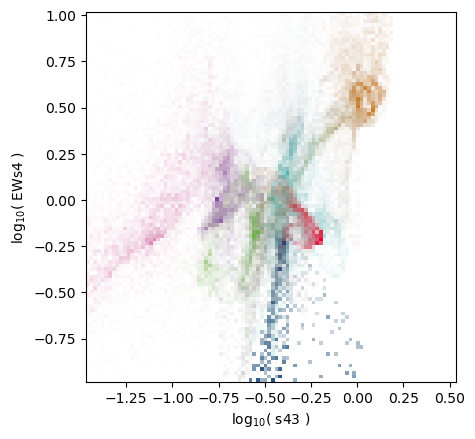

In [76]:
fig, ax = plt.subplots()
color_color_multiweight(ratios["s43"], ratios["EWs4"], zones, ax=ax)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:16: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:17: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:16: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:17: RuntimeWarning: divide by zero encountered in log10  y = np.log10(rat2.ratio[mask])

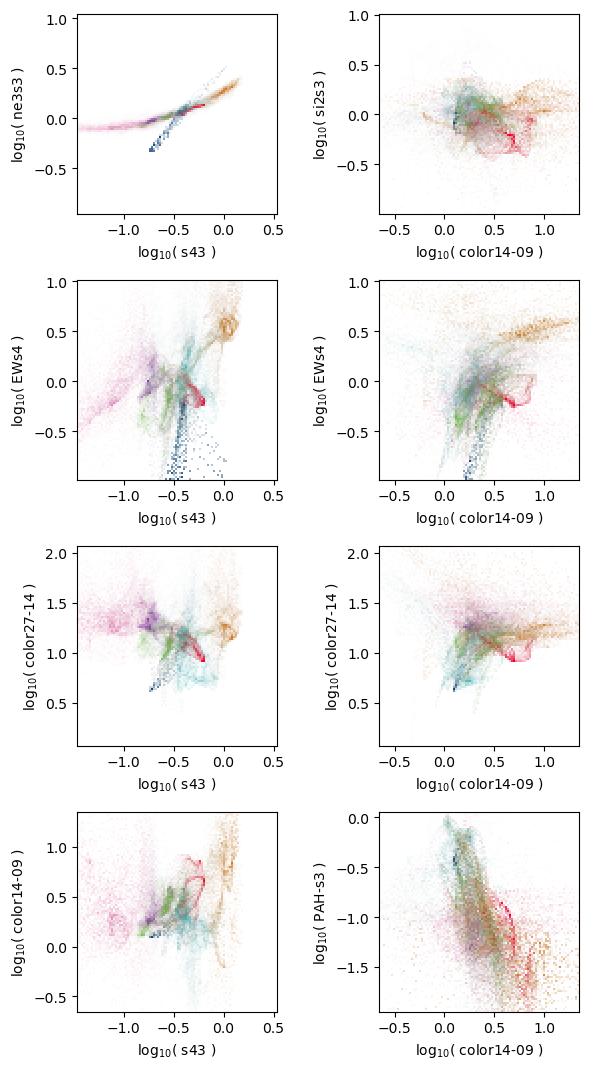

In [77]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
)

color_color_multiweight(ratios["s43"], ratios["ne3s3"], zones, ax=axes[0, 0])
color_color_multiweight(ratios["s43"], ratios["EWs4"], zones, ax=axes[1, 0])
color_color_multiweight(ratios["s43"], ratios["color27-14"], zones, ax=axes[2, 0])
color_color_multiweight(ratios["s43"], ratios["color14-09"], zones, ax=axes[3, 0])

color_color_multiweight(ratios["color14-09"], ratios["si2s3"], zones, ax=axes[0, 1])
color_color_multiweight(ratios["color14-09"], ratios["EWs4"], zones, ax=axes[1, 1])
color_color_multiweight(ratios["color14-09"], ratios["color27-14"], zones, ax=axes[2, 1])
color_color_multiweight(ratios["color14-09"], ratios["PAH-s3"], zones, ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [78]:
fig.savefig("midinfrared-ratio-ratio-plots-zones.pdf", dpi=300, bbox_inches="tight")

#### And an image of the nebula, showing the zones

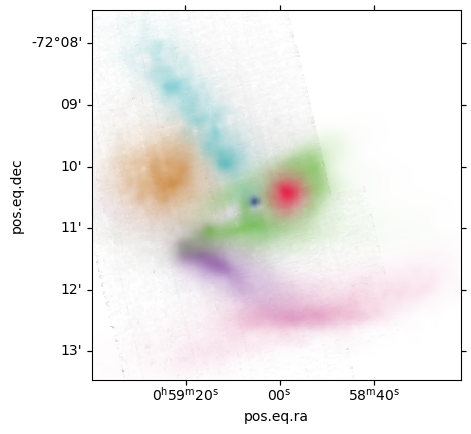

In [79]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w0),)
for zone in zones[:]:
    cmap = sns.light_palette(
        colordb[zone.color],
        input="husl",
        as_cmap=True,
    )
    alpha = np.where(
        np.isfinite(zone.weights) & (zone.weights > 0.0),
        0.8 * zone.max_alpha * zone.weights / np.nanmax(zone.weights),
        0.0
    )
    ax.imshow(
            np.ones_like(zone.weights),
            cmap=cmap,
            interpolation="nearest",
            alpha=alpha,
            vmin=0.0,
            vmax=1.0,
        )


In [80]:
fig.savefig("midinfrared-color-zones.pdf", dpi=300, bbox_inches="tight")

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:16: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:17: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

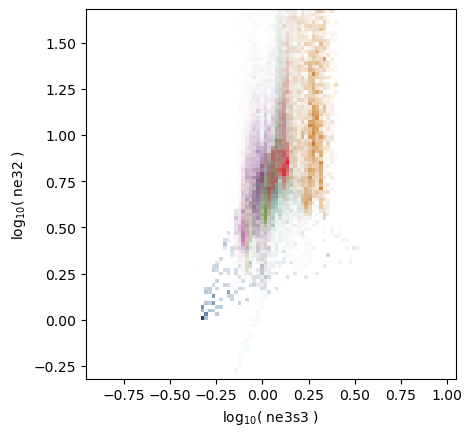

In [81]:
fig, ax = plt.subplots()
color_color_multiweight(ratios["ne3s3"], Ratio("ne32", "Ne III", "Ne II", blur=2.5), zones, ax=ax)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide  numerator / denominator,/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:16: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:16: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:17: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])

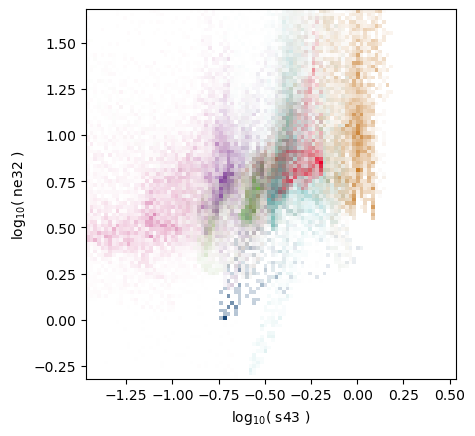

In [92]:
fig, ax = plt.subplots()
color_color_multiweight(ratios["s43"], Ratio("ne32", "Ne III", "Ne II", blur=2.5), zones, ax=ax)

#### Put it all together in a more square figure

We can have a 3 x 3 grid with the 8 ratio-ratio figures around the outside and the celestial image in the center

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:16: RuntimeWarning: invalid value encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:17: RuntimeWarning: invalid value encountered in log10  y = np.log10(rat2.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:16: RuntimeWarning: divide by zero encountered in log10  x = np.log10(rat1.ratio[mask])/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_22468/3255688255.py:17: RuntimeWarning: divide by zero encountered in log10  y = np.log10(rat2.ratio[mask])

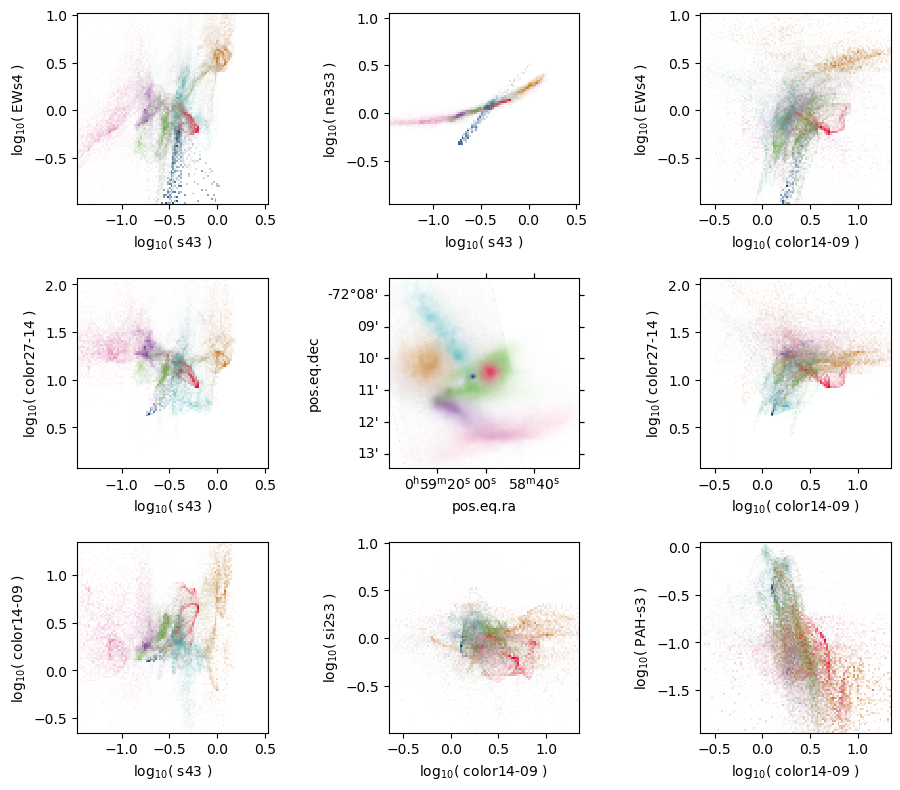

In [82]:
NCOL = 3
NROW = 3
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3. * NCOL, 2.7 * NROW),
)

color_color_multiweight(ratios["s43"], ratios["ne3s3"], zones, ax=axes[0, 1])
color_color_multiweight(ratios["s43"], ratios["EWs4"], zones, ax=axes[0, 0])
color_color_multiweight(ratios["s43"], ratios["color27-14"], zones, ax=axes[1, 0])
color_color_multiweight(ratios["s43"], ratios["color14-09"], zones, ax=axes[2, 0])

color_color_multiweight(ratios["color14-09"], ratios["si2s3"], zones, ax=axes[2, 1])
color_color_multiweight(ratios["color14-09"], ratios["EWs4"], zones, ax=axes[0, 2])
color_color_multiweight(ratios["color14-09"], ratios["color27-14"], zones, ax=axes[1, 2])
color_color_multiweight(ratios["color14-09"], ratios["PAH-s3"], zones, ax=axes[2, 2])

fig.delaxes(axes[1, 1])
axes[1, 1] = fig.add_subplot(3, 3, 5, projection=w0)

for zone in zones[:]:
    cmap = sns.light_palette(
        colordb[zone.color],
        input="husl",
        as_cmap=True,
    )
    if "YSO" in zone.label:
        alpha_adjust = 1.0
    else:
        alpha_adjust = 0.7
    alpha = np.where(
        np.isfinite(zone.weights) & (zone.weights > 0.0),
        alpha_adjust * zone.max_alpha * zone.weights / np.nanmax(zone.weights),
        0.0
    )
    axes[1, 1].imshow(
            np.ones_like(zone.weights),
            cmap=cmap,
            interpolation="nearest",
            alpha=alpha,
            vmin=0.0,
            vmax=1.0,
            origin="lower",
        )

fig.tight_layout(w_pad=3)

In [83]:
fig.savefig("midinfrared-ratio-ratio-plots-3x3-zones.pdf", dpi=300, bbox_inches="tight")

# What happens to the ratio-ratio diagram when you mix two pure states?

I have a feeling that I have calculated this before, and you get straight lines in linear ratio space, but they are curved in the more common case of log ratios. *But it turns out that I was missing some subtleties*



In [84]:
def mix_pure_ratios(
    A_B_1: float, 
    A_B_2: float, 
    f_B_1: np.ndarray | None, 
    f_A_1: np.ndarray | None = None):
    """Calculate the ratio A/B of a mixture of two states 1 and 2
    
    Inputs:
    
    A_B_1: ratio A/B for state 1
    A_B_2: ratio A/B for state 2
    f_B_1: array of fractions of the denominator B emission that comes from state 1
    f_A_1: optiona array of fractions of the numerator A emission that comes from state 1 
           (None by default and if set, then f_B_1 must be None)

    Returns: ratio of the mixture (array of same shape as f_A_1, or f_B_1 if set)
    """
    if f_A_1 is None:
        # case that we know emission fraction of denominator B
        assert np.all(0.0 <= f_B_1) and  np.all(f_B_1 <= 1.0)
        # fraction of B emission from state 2
        f_B_2 = 1 - f_B_1
        # total B emission
        Bsum = f_B_1 + f_B_2
        assert np.allclose(Bsum, 1.0)
        Asum = f_B_1 * A_B_1 + f_B_2 * A_B_2
    else:
        # case that we know emission fraction of numerator A
        assert np.all(0.0 <= f_A_1) and  np.all(f_A_1 <= 1.0)
        assert f_B_1 is None
        # fraction of A emission from state 2
        f_A_2 = 1 - f_A_1
        # total A emission
        Asum = f_A_1 + f_A_2
        assert np.allclose(Asum, 1.0)
        Bsum = f_A_1 / A_B_1 + f_A_2 / A_B_2
       
    return Asum / Bsum

So it turns out that it depends if we know the fraction of the numerator or the denominator. So, we can try out the different cases:
* DD: same denominator on x and y axis
* NN: same numerator on x and y axis
* ND: numerator of x is same as denominator of y
* DN: denominator of x is the same as numerator of y
* M: all 4 quantities are different (numerator and denominator of x and y axes)

Obviously, for case M we cannot trace the mixing lines. But we can for the other cases

In [85]:
def ratio_ratio_xymixline(
    ratrat1: tuple[float, float], 
    ratrat2: tuple[float, float], 
    case: str = "DD",
    nfracs: int = 200,
):
    assert case in ["DD", "NN", "ND", "DN"]
    xrat1, yrat1 = ratrat1
    xrat2, yrat2 = ratrat2
    fracs = np.linspace(0.0, 1.0, nfracs)

    if case[0] == "D":
        xratios = mix_pure_ratios(xrat1, xrat2, f_B_1=fracs, f_A_1=None)
    else:
        xratios = mix_pure_ratios(xrat1, xrat2, f_B_1=None, f_A_1=fracs)

    if case[1] == "D":
        yratios = mix_pure_ratios(yrat1, yrat2, f_B_1=fracs, f_A_1=None)
    else:
        yratios = mix_pure_ratios(yrat1, yrat2, f_B_1=None, f_A_1=fracs)

    return xratios, yratios
    

In [86]:
ratio_ratio_xymixline((1, 0.5), (3, 10), "DD", 10)

(array([3.        , 2.77777778, 2.55555556, 2.33333333, 2.11111111,
        1.88888889, 1.66666667, 1.44444444, 1.22222222, 1.        ]),
 array([10.        ,  8.94444444,  7.88888889,  6.83333333,  5.77777778,
         4.72222222,  3.66666667,  2.61111111,  1.55555556,  0.5       ]))

In [87]:
ratio_ratio_xymixline((1, 0.5), (3, 10), "NN", 10)

(array([3.        , 2.45454545, 2.07692308, 1.8       , 1.58823529,
        1.42105263, 1.28571429, 1.17391304, 1.08      , 1.        ]),
 array([10.        ,  3.21428571,  1.91489362,  1.36363636,  1.05882353,
         0.86538462,  0.73170732,  0.63380282,  0.55900621,  0.5       ]))

In [88]:
import itertools

In [89]:
purestates_ratios = 0.1, 0.3, 1.0, 3.0, 10.0
purestates_xy = list(itertools.product(purestates_ratios, repeat=2))
combos = list(itertools.combinations(purestates_xy, 2))

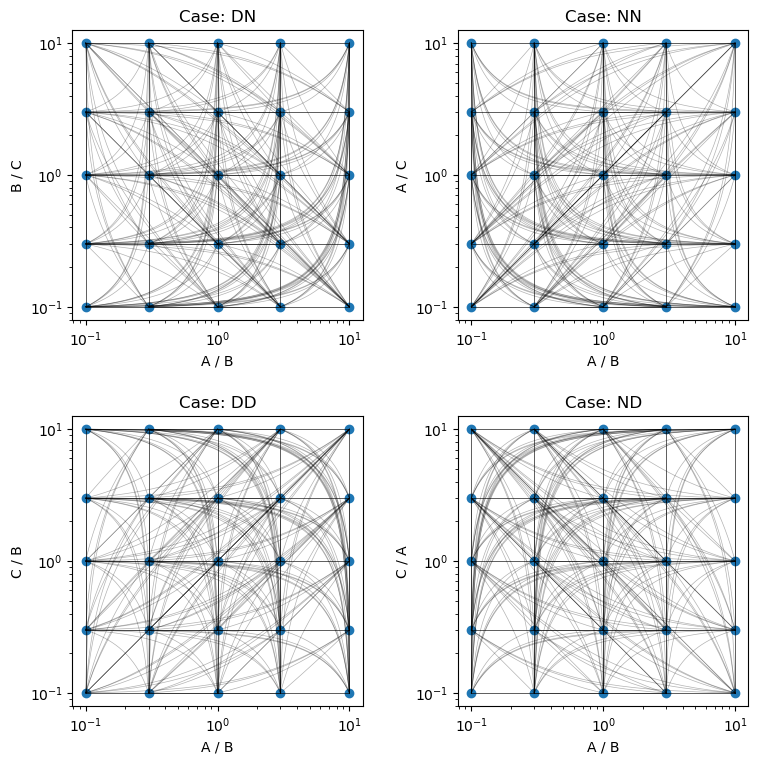

In [90]:
labels = {
    "DD": ("A / B", "C / B"),
    "NN": ("A / B", "A / C"),
    "DN": ("A / B", "B / C"),
    "ND": ("A / B", "C / A"),
}

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, xcase in enumerate("DN"):
    for j, ycase in enumerate("DN"):
        ax = axes[1 - j, i]
        case = xcase + ycase
        xlabel, ylabel = labels[case]
        ax.scatter(*zip(*purestates_xy))
        for xy1, xy2 in combos:
            ax.plot(
                *ratio_ratio_xymixline(xy1, xy2, case=case), 
                color="k", 
                linewidth=0.5,
                alpha=0.3,
            )
        ax.set(
            xscale="log",
            yscale="log",
            xlabel=xlabel,
            ylabel=ylabel,
        )
        ax.set_aspect("equal")
        ax.set_title(f"Case: {case}")

fig.tight_layout(pad=2)

In [91]:
fig.savefig("ratio-ratio-mixing-line-plots.pdf", dpi=300, bbox_inches="tight")